In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o")
small_llm = ChatOpenAI(model_name="gpt-4o-mini")


In [3]:
from langchain_core.tools import tool

# Required: tool decorator, expected arguments, description
@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다"""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다"""
    return a * b

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

# search_tool.invoke("Obama's first name ?")

In [5]:
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)
from langchain_google_community.gmail.toolkit import GmailToolkit

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
# 1. Google credential 받기
# 2. Gmail API 활성화하기
credentials = get_gmail_credentials(
    token_file="./google/token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/client_secret_956757050949-dh18vafkhg3aqmq0tigt1es79q2qisb6.apps.googleusercontent.com.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x7f7d99a4d6a0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x7f7d99a4d6a0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x7f7d99a4d6a0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x7f7d99a4d6a0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x7f7d99a4d6a0>)]

In [6]:
from langchain.agents import load_tools

loaded_tools_list = load_tools(["arxiv"])

In [19]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_chroma import Chroma

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

# text_path = "./docs/real_estate_tax.txt"
# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size = 1500,
#     chunk_overlap = 100,
#     separators=['\n\n', '\n']
# )
# loader = TextLoader(text_path)
# document_list = loader.load_and_split(text_splitter)

# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embedding_function,
#     collection_name = 'real_estate_tax',
#     persist_directory = './real_estate_tax_collection'
# )

vector_store = Chroma(
    collection_name="real_estate_tax",
    embedding_function=embedding_function,
    persist_directory="./real_estate_tax_collection",
)

retriever = vector_store.as_retriever()
retriever_tool = create_retriever_tool(retriever, "retriever", "Contains information about real estate tax up to December 2024")

In [20]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tools_list
llm_with_tools = llm.bind_tools(tool_list)
# AnyMessage(System, Human, AI, Tool) 리스트를 입력으로 받아야한다.
# 마지막은 AI message 이어야하고, 해당 메시지에 tool_calls가 있어야한다.
tool_node = ToolNode(tool_list)

In [21]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)


In [22]:
def agent(state: MessagesState):
    message = state["messages"]
    response = llm_with_tools.invoke(message)
    return {"messages": [response]}

In [ ]:
# Agent는 tool을 사용할 필요가 없을 때 메시지에 tool_calls가 없고, content에 답변이 들어가게된다 는 점을 이용

# from langgraph.graph import END
# def should_continue(state: MessagesState):
#     message = state["messages"]
#     last_ai_message = message[-1]
#     if last_ai_message.tool_calls:
#         return 'tools'
#     return END

In [24]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)


In [ ]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

graph_builder.add_edge(START, 'agent')
# graph_builder.add_conditional_edges("agent", should_continue, ["tools", END])
graph_builder.add_conditional_edges("agent", tools_condition)
graph_builder.add_edge("tools", "agent")



In [26]:
graph = graph_builder.compile()

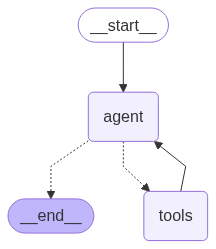

In [27]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
from langchain_core.messages import HumanMessage

query = "집이 15억일 때 2024년 종합부동산세를 계산해줄 수 있나요?"
for chunk in graph.stream({"messages": [HumanMessage(content=query)]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

집이 15억일 때 2024년 종합부동산세를 계산해줄 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  retriever (call_fdIXzjiJiW7DduN7YoKamYNO)
 Call ID: call_fdIXzjiJiW7DduN7YoKamYNO
  Args:
    query: 2024 이십오억 종합부동산세 계산
================================= Tool Message =================================
Name: retriever

납세의무자가 2주택 이하를 소유한 경우

| 과세표준              | 세율                                  |
|---------------------|-------------------------------------|
| 3억 원 이하           | 1천분의 5                              |
| 3억 원 초과 6억 원 이하 | 150만 원 + (3억 원을 초과하는 금액의 1천분의 7)  |
| 6억 원 초과 12억 원 이하 | 360만 원 + (6억 원을 초과하는 금액의 1천분의 10) |
| 12억 원 초과 25억 원 이하 | 960만 원 + (12억 원을 초과하는 금액의 1천분의 13)|
| 25억 원 초과 50억 원 이하 | 2천650만 원 + (25억 원을 초과하는 금액의 1천분의 15)|
| 50억 원 초과 94억 원 이하 | 6천400만 원 + (50억 원을 초과하는 금액의 1천분의 20)|
| 94억 원 초과          | 1억 5천200만 원 + (94억 원을 초과하는 금액의 1천분의 27)|

납세의무자가 3